# Bahdanau注意力

In [1]:
import torch
import math
from d2l import torch as d2l
from torch import nn

# ========== 自定义 EncoderDecoder 类 ==========
class EncoderDecoder(nn.Module):
    """
    编码器-解码器架构的基类
    
    这个类将编码器和解码器组合在一起，实现序列到序列的模型。
    前向传播时：
    1. 编码器处理输入序列，得到编码输出和隐藏状态
    2. 解码器使用编码器的输出初始化解码状态
    3. 解码器处理解码输入，返回预测结果和状态
    """
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, enc_X, dec_X, *args):
        """
        前向传播
        
        参数:
            enc_X: 编码器输入，形状 (batch_size, num_steps)
            dec_X: 解码器输入，形状 (batch_size, num_steps)
            *args: 额外的参数，例如 enc_valid_lens（编码器输入的有效长度）
        
        返回:
            dec_output: 解码器输出，形状 (batch_size, num_steps, vocab_size)
            dec_state: 解码器状态，用于后续时间步
        """
        # 编码器处理输入序列
        # enc_outputs 通常是 (outputs, hidden_state) 的元组
        enc_outputs = self.encoder(enc_X, *args)
        
        # 解码器使用编码器输出初始化解码状态
        # *args 可能包含 enc_valid_lens 等参数
        dec_state = self.decoder.init_state(enc_outputs, *args)
        
        # 解码器处理解码输入，返回输出和状态
        # 返回格式: (dec_output, dec_state)
        return self.decoder(dec_X, dec_state)

# ========== 自定义基础类 ==========
class Encoder(nn.Module):
    """编码器-解码器架构的基本编码器接口"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)
    
    def forward(self, X, *args):
        raise NotImplementedError

class Decoder(nn.Module):
    """编码器-解码器架构的基本解码器接口"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)
    
    def init_state(self, enc_outputs, *args):
        """将编码器的输出转换为编码后的状态"""
        raise NotImplementedError
    
    def forward(self, X, state):
        """前向传播"""
        raise NotImplementedError

# ========== 工具函数 ==========
def masked_softmax(X, valid_lens):
    """带掩码的softmax函数"""
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

class AdditiveAttention(nn.Module):
    """加性注意力（Additive Attention），也称为 Bahdanau Attention"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs) -> None:
        super().__init__()
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.W_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.W_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [2]:
class AttentionDecoder(Decoder):
    """
    带注意力机制的解码器基类
    
    继承自 Decoder，添加了 attention_weights 属性
    用于存储和访问注意力权重
    """
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)
    
    @property
    def attention_weights(self):
        """返回注意力权重"""
        raise NotImplementedError

In [3]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        # 使用我们定义的 AdditiveAttention
        # 参数: key_size=num_hiddens, query_size=num_hiddens, num_hiddens=num_hiddens, dropout=dropout
        # 因为在 Bahdanau 注意力中，query 和 key 都是编码器的隐藏状态，维度相同
        self.attention = AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        """
        初始化解码器状态
        
        参数:
            enc_outputs: 编码器输出，是一个元组 (outputs, hidden_state)
                - outputs: (num_steps, batch_size, num_hiddens)
                - hidden_state: (num_layers, batch_size, num_hiddens)
            enc_valid_lens: 编码器输入的有效长度
            *args: 额外的参数（未使用）
        
        返回:
            解码器状态，是一个元组 (enc_outputs, hidden_state, enc_valid_lens)
        """
        # outputs的形状为(num_steps, batch_size, num_hiddens)
        # hidden_state的形状为(num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        # 将 outputs 从 (num_steps, batch_size, num_hiddens) 
        # 转换为 (batch_size, num_steps, num_hiddens)
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size,
        # num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        # 返回2个值：输出和状态
        # 输出形状: (batch_size, num_steps, vocab_size)
        # 状态: [enc_outputs, hidden_state, enc_valid_lens]
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [4]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (batch_size,num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

loss 0.019, 16101.0 tokens/sec on cpu


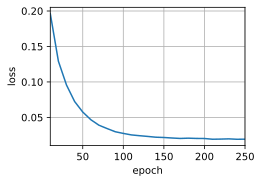

In [5]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
# 使用自定义的 EncoderDecoder 而不是 d2l.EncoderDecoder
net = EncoderDecoder(encoder, decoder)

# 测试一下返回值
net.eval()
X = torch.zeros((2, 7), dtype=torch.long, device=device)
dec_input = torch.zeros((2, 7), dtype=torch.long, device=device)
X_valid_len = torch.tensor([7, 7], device=device)
try:
    result = net(X, dec_input, X_valid_len)
    print(f"返回值数量: {len(result) if isinstance(result, tuple) else 1}")
    print(f"返回值类型: {type(result)}")
    if isinstance(result, tuple):
        print(f"第一个值形状: {result[0].shape if hasattr(result[0], 'shape') else 'N/A'}")
        print(f"第二个值类型: {type(result[1])}")
        print("✓ 返回值格式正确！")
except Exception as e:
    print(f"错误: {e}")
    import traceback
    traceback.print_exc()

# 如果测试通过，再开始训练
print("\n开始训练...")
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [6]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True
    )
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est mouillé .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [7]:
print(dec_attention_weight_seq)
# 这里将解码器每一步的注意力权重取出来，拼接在一起，方便后续可视化。
# dec_attention_weight_seq 记录了每一步的注意力权重（形如[batch_size, num_heads, query_len, key_len]）
# 这里我们只取第一个 batch、第一头、第一位置的注意力（即 step[0][0][0]），把每一步的拼接起来
# 得到的 attention_weights 形状为 (1, 1, 解码步数, 输入序列长度)
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
    1, 1, -1, num_steps))

[[tensor([[[0.1000, 0.3295, 0.3536, 0.2169, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]]], grad_fn=<SoftmaxBackward0>)], [tensor([[[0.0327, 0.3713, 0.3659, 0.2301, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]]], grad_fn=<SoftmaxBackward0>)], [tensor([[[0.0492, 0.3062, 0.3487, 0.2959, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]]], grad_fn=<SoftmaxBackward0>)], [tensor([[[0.0389, 0.3614, 0.4382, 0.1615, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]]], grad_fn=<SoftmaxBackward0>)], [tensor([[[0.0308, 0.3016, 0.3778, 0.2899, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]]], grad_fn=<SoftmaxBackward0>)], [tensor([[[0.0217, 0.3750, 0.3922, 0.2110, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]]], grad_fn=<SoftmaxBackward0>)]]


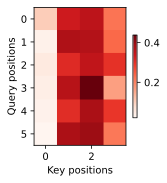

In [8]:
# 加上一个包含序列结束词元
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

## 注意力权重热力图详解

### 什么是注意力权重热力图？

注意力权重热力图展示了**解码器在每个时间步（Query）对编码器不同位置（Key）的关注程度**。

### 图的组成部分

#### 1. **坐标轴**
- **Y轴（Query positions）**：解码器的不同时间步
  - 0, 1, 2, 3, 4, 5 表示解码器生成第1、2、3、4、5、6个词时的状态
  - 每个 Query 代表"当前要生成什么词时，我应该关注编码器的哪些位置"
  
- **X轴（Key positions）**：编码器输入序列的不同位置
  - 0, 1, 2 表示编码器输入序列的第1、2、3个位置
  - 每个 Key 代表"编码器在这个位置的信息"

#### 2. **颜色深浅**
- **颜色越深（红色）**：注意力权重越大，表示**更关注**
- **颜色越浅（白色）**：注意力权重越小，表示**不太关注**
- **颜色条（Colorbar）**：显示具体的数值范围（0到0.4）

### 如何理解这个图？

#### 示例解读：

假设我们在做**机器翻译**：
- **编码器输入**（Key positions）：
  - 位置0: "我"
  - 位置1: "爱"
  - 位置2: "你"

- **解码器输出**（Query positions）：
  - Query 0: 生成 "I" 时
  - Query 1: 生成 "love" 时
  - Query 2: 生成 "you" 时
  - ...

#### 观察模式：

1. **Key Position 0（第一列）**：
   - 几乎全是白色 → 所有 Query 都不太关注位置0
   - 可能这个位置是填充（padding）或不太重要的词

2. **Key Position 1（第二列）**：
   - Query 2, 3, 4 显示较深的红色 → 这些时间步更关注位置1
   - 可能位置1包含重要信息

3. **Key Position 2（第三列）**：
   - Query 2, 3, 4 显示最深的红色 → **最强的注意力**
   - 说明在生成中间几个词时，模型最关注编码器的位置2

### 实际意义

这个图告诉我们：
- **模型学会了对齐**：解码器在生成不同词时，会关注编码器的不同位置
- **注意力分布**：不是均匀分布，而是有选择性地关注重要位置
- **翻译对齐**：在机器翻译中，这通常对应源语言和目标语言的词对齐关系

### 为什么重要？

1. **可解释性**：可以看到模型"在看哪里"
2. **调试工具**：检查注意力是否合理
3. **对齐信息**：在翻译任务中，可以看到词与词之间的对应关系
